<a href="https://colab.research.google.com/github/Hrushi1812/Technical-indicators/blob/main/Task2_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 703.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218907 sha256=46918085778b182fd2baa73b4fd4700f907ecf0494b57c30142756e8adbe20fa
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
def get_stock_data(symbol, start_date, end_date):
    data = yf.download(symbol, start=start_date, end=end_date)
    return data

In [66]:
symbol = 'IOC.NS'
start_date = '2019-01-01'
end_date = '2024-01-01'

**Generating Signals:-**

This strategy combines short-term (20-period) and long-term (50-period) exponential moving averages (EMAs) with the relative strength index (RSI) to generate buy and sell signals for a financial instrument. Buy signals occur when the short-term EMA is above the long-term EMA, while sell signals occur when the short-term EMA is below the long-term EMA. Exit signals are triggered based on RSI values (above 70 for selling and below 30 for covering short positions), helping manage risk in overbought or oversold market conditions.

In [67]:
def generate_signals(data):
    signals = pd.DataFrame(index=data.index)
    signals['Short_EMA'] = ta.ema(data['Close'], length=20)
    signals['Long_EMA'] = ta.ema(data['Close'], length=50)
    signals['RSI'] = ta.rsi(data['Close'], length=14)

    # Generate trading signals
    signals['Signal'] = 0
    signals.loc[signals['Short_EMA'] > signals['Long_EMA'], 'Signal'] = 1  # Buy signal
    signals.loc[signals['Short_EMA'] < signals['Long_EMA'], 'Signal'] = -1  # Short signal

    # Exit signals
    signals['Exit_Signal'] = 0
    signals.loc[(signals['RSI'] > 70) & (signals['Signal'] == 1), 'Exit_Signal'] = 1  # Exit long
    signals.loc[(signals['RSI'] < 30) & (signals['Signal'] == -1), 'Exit_Signal'] = -1  # Exit short

    return signals

**Calculating PnL:-**

This function calculates the profit and loss (P&L) of a trading strategy based on buy and sell signals. It starts with an initial capital and tracks the portfolio's value over time. The strategy involves buying or selling stocks based on signals, and the function computes daily returns. If the "compound" parameter is set to True, it calculates the compounded returns; otherwise, it provides simple daily returns. The resulting portfolio includes information about stock positions, cash holdings, total portfolio value, and returns, allowing for an evaluation of the strategy's performance.

In [89]:
def calculate_pnl(data, signals, initial_capital, compound=True):
    positions = pd.DataFrame(index=data.index)
    positions['Position'] = signals['Signal']
    positions['Stock'] = 1000 * positions['Position']

    # Daily portfolio value
    portfolio = positions.multiply(data['Close'], axis=0)
    pos_diff = positions.diff()

    # Add cash holdings to the portfolio
    portfolio['Cash'] = initial_capital - (pos_diff['Stock'] * data['Close']).cumsum()

    # Total portfolio value
    portfolio['Total'] = portfolio['Stock'] + portfolio['Cash']

    # Daily returns
    portfolio['Returns'] = portfolio['Total'].pct_change()

    if compound:
        portfolio['Returns'] = (1 + portfolio['Returns']).cumprod() - 1

    return portfolio

In [90]:
def plot_results(data, signals, pnl):

    plt.style.use('seaborn-darkgrid')

    fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

    # Plotting Cumulative PnL
    axes[0].plot(pnl['Total'][49:], label='Cumulative PnL (Equity Curve)', color='purple')
    axes[0].set_title('Cumulative PnL (Equity Curve)')
    axes[0].legend(loc='upper left')

    # Plotting Drawdown Chart
    drawdown = (pnl["Total"][49:] / pnl["Total"][49:].cummax() - 1) * 100
    axes[1].plot(drawdown, label='Drawdown', color='red')
    axes[1].set_title('Drawdown Chart')
    axes[1].legend(loc='upper left')

    # Plotting Volatility
    axes[2].plot(pnl["Returns"][49:].rolling(window=20).std(), label='Volatility', color='orange')
    axes[2].set_title('Volatility')
    axes[2].legend(loc='upper left')

    plt.tight_layout()
    plt.show()

In [103]:
stock_data = get_stock_data(symbol, start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


<ipython-input-90-31a430837de9>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


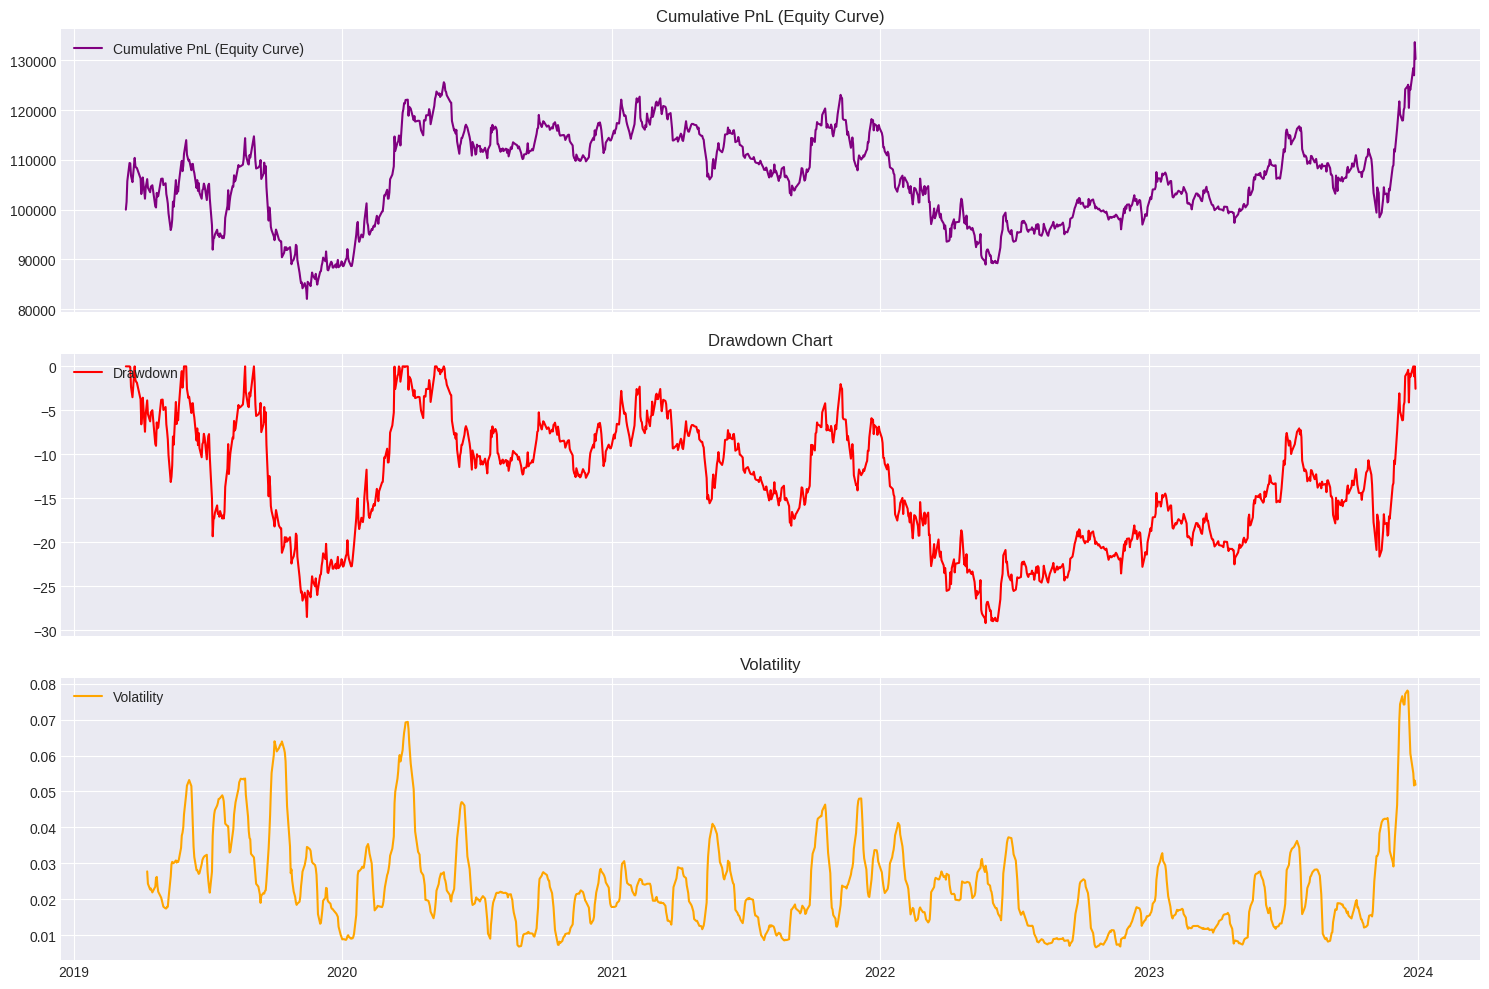

In [102]:
signals = generate_signals(stock_data)

pnl = calculate_pnl(stock_data, signals,100000)

# Plot results
plot_results(stock_data, signals, pnl)

**Benchmark:-**

Benchmark is buy and hold return for the stock over the given time period.
Here we buy as many shares with our initial investment and hold them for 5 years.

In [99]:
import math
initial_capital = 100000
shares = math.floor(initial_capital / stock_data["Close"][0])
total_return = (stock_data["Close"][-1] - stock_data["Close"][0]) * shares
percent_return = (total_return / initial_capital) * 100
strategy_return = ((pnl["Total"][-1] - initial_capital) / (initial_capital)) * 100

In [101]:
print(f"Benchmark return is {percent_return}")
print(f"Strategy return is {strategy_return}")

Benchmark return is 41.43645332336426
Strategy return is 30.249992370605465
